Last updated: 27 Jul 2018

# Exploring US Endangered Species Data with Python

This notebook retrieves data from the US Fish & Wildlife Service on endangered and threatened species. It runs a simple analysis and returns a visualization of types and locations of species.

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup 
import pandas as pd
import re, requests
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

## Data Source

Data are retrieved from the U.S. Fish & Wildlife Service [Environmental Conservation Online System](https://ecos.fws.gov/ecp/), which reports on Threatened & Endangered species in the United Statesthat are protected by the Endangered Species Act. 

There are a number of different reports are available here: https://ecos.fws.gov/ecp/species-reports. They are mostly provided as sortable tables, viewable online.

## What question are we asking?

After looking at some of the available datasets, it seems like there are data available on how many requests were made to list species, when species were officially listed, and in what US states they can be found.

For the purposes of this analysis, I would like to ask the following questions:

> *1. Which US states are most effective at getting species listed under the Endangered Species Act?*

> *2. How has the rate of getting species listed changed over time?*

## 1. Which US states are most effective at getting species listed under the Endangered Species Act?



## 2. Listing species over time



We can scrape the [U.S. Federal Endangered and Threatened Species by Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report) report to get counts of species listed by year. 

In [2]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report'
r = requests.get(url)
soup = BeautifulSoup(r.text, "html5lib")
rows = soup.table.find_all('tr')
listing_years = set()
for row in rows:
    values = row.find_all('td')
    if len(values) > 0:
        listing_years.add(values[0].string)
listing_years = sorted(list(listing_years))
print(", ".join(listing_years))

1967, 1970, 1972, 1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018


Unfortunately, there is some redundancy in the reported counts, so we can't rely on these numbers alone to get accurate counts. We can get a list of reported years.

We can take the list of years we determined from the last step, and query the [Species Listed During Calendar Year](https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report?year=2018) reports for each year in `listing_years`.

In [3]:
url = 'https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report'
all_species = []
for y in listing_years:
    params = {'year': y}
    r = requests.get(url, params)
    soup = BeautifulSoup(r.text, "html5lib")
    rows = soup.table.find_all('tr')
    for row in rows:
        species = {}
        data = row.find_all('td')
        if len(data) > 0:
            splink = data[2].a['href']
            spcode = re.findall('spcode=(\w{4})', splink)[0]
            species['spcode'] = spcode
            species['sciname'] = data[2].string
            species['status'] = data[3].string
            species['listyear'] = y
            all_species.append(species)
print(f'{len(all_species)} species records read from Species Listed During Calendar Year')

3579 species records read from Species Listed During Calendar Year


We can take the `all_species` records and put them into a pandas DataFrame. We can also drop the duplicate values that were throwing off the original counts.

In [4]:
df_years = pd.DataFrame(all_species)
df_years = df_years[['spcode', 'sciname', 'status', 'listyear']]
df_years = df_years.drop_duplicates()
print(f'{len(df_years)} species records remaining after dropping duplicates')

1811 species records remaining after dropping duplicates


Summarize the data table - counts by year

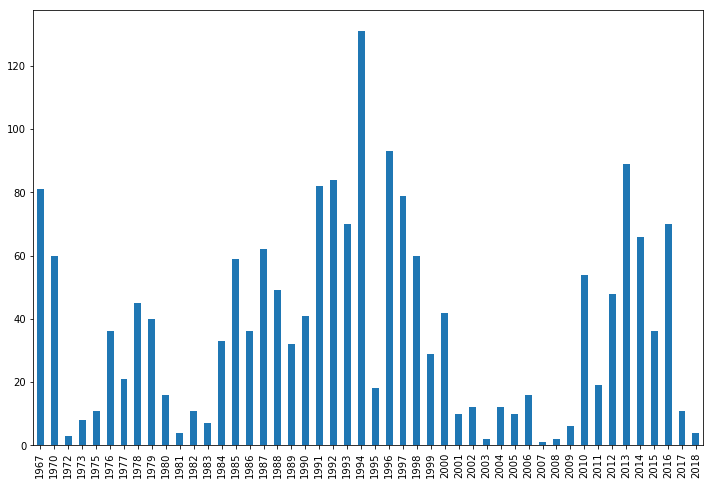

In [5]:
year_counts = df_years['listyear'].value_counts().sort_index()
year_counts.plot(kind='bar');

In [22]:
url = 'https://ecos.fws.gov/ecp/report/table/petitions-received.json'
params = {'active': 'any'}
r = requests.get(url, params).json()

In [23]:
columnheaders = [x['title'] for x in r['metadata']['columns']]
print(columnheaders)

['Petition Title', 'Date Received by the FWS', 'Where the species is believed to or known to occur', 'Petitioner Name', 'Requested Action', 'Petition Finding(s)', 'Active', 'Petitions Document(s)']


In [24]:
df_petitions = pd.DataFrame(r['data'], columns=columnheaders)
len(df_petitions)

750

When you examine several reports, you can see that they are all generated from one endpoint: `https://ecos.fws.gov/ecp0/reports/ad-hoc-species-report`

By providing a specific query string, you can generate a custom report of the preferred fields and types of organisms.

In [ ]:
url = 'https://ecos.fws.gov/ecp0/reports/ad-hoc-species-report'
params = {
    'kingdom': 'V', 'kingdom': 'I', 'kingdom': 'P',
    'status': 'E', 'status': 'T',
    'mapstatus': 3, 
    'fstatus': 'on', 'finvpop': 'on', 'fgroup': 'on', 'ffamily': 'on',
    'header': 'Listed Vertebrates, Invertebrates, and Plants'
}
r = requests.get(url, params)
with open('endangered_threatened_species.txt', 'w') as f:
    f.write(r.text)

Counts every species ever listed as threatened or endangered under the Endangered Species Act (inc. distinct population segments)

https://ecos.fws.gov/ecp0/reports/species-listings-count-by-year-report

https://ecos.fws.gov/ecp0/reports/species-listings-by-year-report?year=2018

Endangered species listings petitions received

https://ecos.fws.gov/ecp/report/table/petitions-received.json

https://ecos.fws.gov/ecp/report/table/petitions-received.json?&active=any

Formatted weird - first dict item is "metadata", which contains all the column names. Second dict item is "data", which contains a list of lists. Items do not have keys, they must be positionally relayed to the metadata.


In [ ]:
r2 = requests.get('https://ecos.fws.gov/ecp/report/table/petitions-received.json?&active=any')
with open('listings_requests.json', 'w', encoding='utf-8') as f2:
    f2.write(r2.text)